In [ ]:
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/ronald/Schistossoma/Schistossoma_functions')
from k_means_general_functions import *


In [ ]:
'''Gera listas com nomes dos arquivos PL, correspondentes nomes dos arquivos SHG e as respectivas acumulações'''

path = '/home/ronald/imagens_fígado'

archives_PL_list, correspondent_archives_SHG, correspondent_accumulation_PL, correspondent_accumulation_SHG = generate_list_PL_and_SHG_archives_names_and_accumulations(path)

In [ ]:
%%skip
'''Exibir imagens PL e SHG'''
for i in range(len(archives_PL_list)):
    PL_image = ski.io.imread(os.path.join(path, archives_PL_list[i]))[0, :, :, 1]
    SHG_image = ski.io.imread(os.path.join(path, correspondent_archives_SHG[i]))[:, :, 1]
    exib_figures(PL_image, SHG_image, 
                 'pure_red', 'pure_green', 
                 np.max(PL_image), np.max(SHG_image),
                 'PL', 'SHG',
                 path_and_name_figure = None)

In [ ]:
%%skip
'''Exibir imagem SHG e estimativa de ruído com filtro passa baixa gaussiano via cv2'''
import cv2
for i in range(len(archives_PL_list)):
    PL_image = ski.io.imread(os.path.join(path, archives_PL_list[i]))[0, :, :, 1]
    SHG_image = ski.io.imread(os.path.join(path, correspondent_archives_SHG[i]))[:, :, 1]
    SHG_image_normalizada = SHG_image/correspondent_accumulation_SHG[i]
    blur = cv2.GaussianBlur(SHG_image_normalizada, (3,3), 0)
    ruido_estimado = abs(cv2.subtract(SHG_image_normalizada, blur))
    exib_figures(SHG_image, ruido_estimado, 
                 'pure_green', 'pure_green', 
                 np.max(SHG_image), np.max(ruido_estimado),
                 'SHG', 'Noise',
                 path_and_name_figure = None)

In [ ]:
%%skip
'''Exibir histogramas das imagens de ruídos obtidas com filtro passa baixa gaussiano'''
import cv2
for i in range(len(archives_PL_list)):
    if i % 2 == 0:
        PL_image = ski.io.imread(os.path.join(path, archives_PL_list[i]))[0, :, :, 1]
        SHG_image = ski.io.imread(os.path.join(path, correspondent_archives_SHG[i]))[:, :, 1]
        SHG_image_normalizada = SHG_image/correspondent_accumulation_SHG[i]
        blur = cv2.GaussianBlur(SHG_image_normalizada, (5,5), 0)
        ruido_estimado = abs(cv2.subtract(SHG_image_normalizada, blur))
    if i % 2 == 1:
        PL_image_2 = ski.io.imread(os.path.join(path, archives_PL_list[i]))[0, :, :, 1]
        SHG_image_2 = ski.io.imread(os.path.join(path, correspondent_archives_SHG[i]))[:, :, 1]
        SHG_image_normalizada_2 = SHG_image_2/correspondent_accumulation_SHG[i]
        blur_2 = cv2.GaussianBlur(SHG_image_normalizada_2, (5,5), 2)
        ruido_estimado_2 = abs(cv2.subtract(SHG_image_normalizada_2, blur_2))
        '''exib_figures(PL_image, SHG_image, 
                 'pure_red', 'pure_green', 
                 np.max(PL_image), np.max(SHG_image),
                 'PL', 'SHG',
                 path_and_name_figure = None)'''
        '''exib_figures(SHG_image_2, ruido_estimado_2, 
                 'pure_green', 'pure_green', 
                 np.max(SHG_image_2), np.max(ruido_estimado_2),
                 'SHG', 'Noise',
                 path_and_name_figure = None)'''
        plot_histograms_side_by_side(ruido_estimado, ruido_estimado_2,
                                 '', '',
                                 overall_title = '',
                                 path_save = None) 

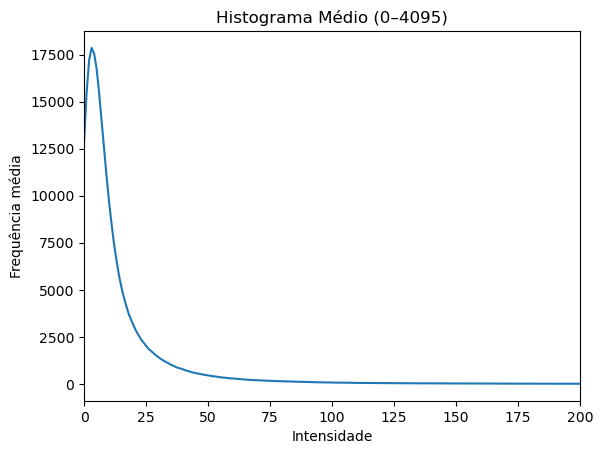

In [5]:
'''Calcular histograma médio''' 
from skimage import io
import cv2
bins = 4096
hist_sum = np.zeros(bins)
for i in range(len(archives_PL_list)):
    SHG_image = ski.io.imread(os.path.join(path, correspondent_archives_SHG[i]))[:, :, 1]
    SHG_image_normalizada = SHG_image/correspondent_accumulation_SHG[i]
    blur = cv2.GaussianBlur(SHG_image_normalizada, (5,5), 0)
    ruido_estimado = abs(cv2.subtract(SHG_image_normalizada, blur)).astype(np.uint32)
    hist, _ = np.histogram(ruido_estimado, bins=bins, range=(0, 4095))
    hist_sum += hist
hist_mean = hist_sum / len(archives_PL_list)
plt.plot(hist_mean)
plt.title("Histograma Médio (0–4095)")
plt.xlabel("Intensidade")
plt.ylabel("Frequência média")
plt.xlim(0, 200)   # <-- limita o eixo horizontal
plt.show()

/tmp/ipykernel_12137/3190983430.py:43: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, valores, contagens, p0=[max(contagens),


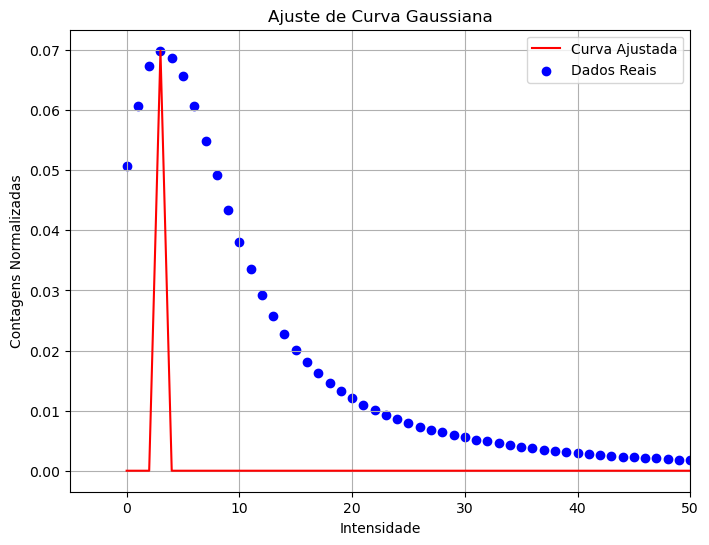

In [8]:
'''Ajuste de curva sobre histograma'''
# Valores de intensidade (0 a 4095)
valores = list(range(4096))

# Contagens médias do histograma
contagens = hist_mean.tolist()

#Índice do primeiro valor de intensidade cuja contagem é nula
indice_x_max = np.where(np.array(contagens) <= 0.01*max(contagens))[0][0] 

# Intensidade com contagem máxima
intensidade_contagem_max = valores[np.argmax(hist_mean)]

#Trunca as intensidades possíveis
valores = valores[:indice_x_max]
contagens = contagens[:indice_x_max]

#Normaliza as contagens
contagens = np.array(contagens)/sum(contagens)


#Ajuste Gaussiano
from scipy.optimize import curve_fit

def gaussian(x, a, mu, sigma):
    """
    Função Gaussiana para ajuste de curva.

    Parâmetros:
    ----------
    x: array
        Variável independente.
    a: float
        Amplitude máxima da curva.
    mu: float
        Média da curva (centro).
    sigma: float
        Desvio padrão da curva (largura).
    """
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))


popt, pcov = curve_fit(gaussian, valores, contagens, p0=[max(contagens), 
                                                         intensidade_contagem_max, 
                                                         np.std(np.array(contagens))])

'''
popt: array com os parâmetros ótimos ajustados (a, mu, sigma)
pcov: matriz de covariância dos parâmetros
gaussian: função definida, que pretende-se ajustar à dispersão dos dados
p0: chutes iniciais para os parâmetros

'''

# Gera a curva ajustada usando os parâmetros otimizados
y_ajustado = gaussian(valores, *popt)

plt.figure(figsize=(8, 6))
plt.plot(valores, y_ajustado, label='Curva Ajustada', color='red')
plt.scatter(valores, contagens, label='Dados Reais', color='blue')
plt.title('Ajuste de Curva Gaussiana')
plt.xlabel('Intensidade')
plt.ylabel('Contagens Normalizadas')
plt.legend()
plt.grid(True)
plt.xlim(-5,50)
plt.show()


# Curva de Cauchy-Lorentz
$f(x)=\frac{A}{1+\left(\frac{x-x_0}{\gamma}\right)^2}$, ou, em sua forma normalizada, $f(x)=\frac{1}{\pi\gamma\left[1+\left(\frac{x-x_0}{\gamma}\right)^2\right]}$, onde $A$ é a amplitude, $x_0$ é o a posição do pico central e $\gamma$ a largura da curva a meia altura.



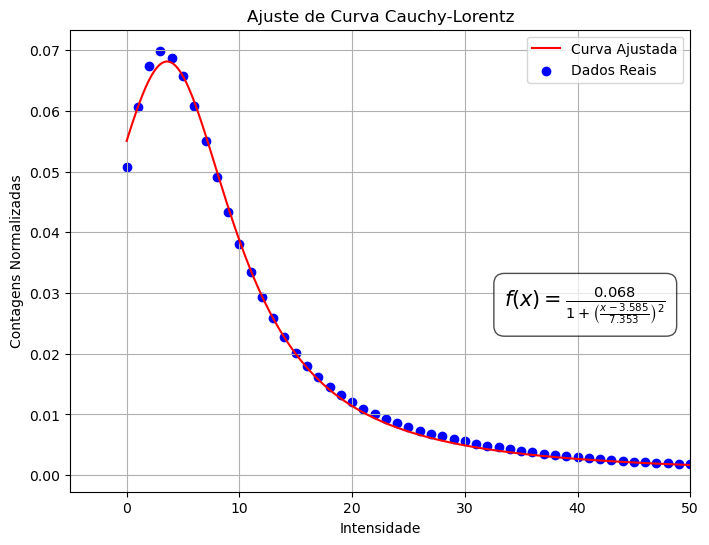

In [9]:
from numpy import interp
def estimar_pars(x,y):
    y_max = max(y)
    x_0 = x[np.argmax(y)]
    
    #Converte listas para arrays
    x = np.array(x)
    y = np.array(y)
    
    # Separa lados direito e esquerdo da curva
    x_left = x[x < x_0]
    y_left = y[x < x_0]
    x_right = x[x > x_0]
    y_right = y[x > x_0]
    
    #Interpola para achar os valores aproximados da coordenada x para os pontos a meia altura
    x_left_half = interp(y_max/2, y_left[::-1], x_left[::-1])  # do lado esquerdo
    x_right_half = interp(y_max/2, y_right, x_right)           # do lado direito
    
    #Largura aproximada a meia altura
    fwhm_guess = (x_right_half - x_left_half)/2
    
    return y_max, x_0, fwhm_guess

def cauchy_lorentz(x, A, x_0, gamma):
    """
    Função de Cauchy-Lorentz para ajuste de curva.

    Parâmetros:
    ----------
    x: array
        Variável independente.
    A: float
        Amplitude máxima da curva.
    x_0: float
        Posição do pico central.
    gamma: float
        Largura a meia altura.
    """
    return A/(1+((x-x_0)/(gamma))**2)


popt_cl, pcov_cl = curve_fit(cauchy_lorentz, valores, contagens, p0=[estimar_pars(valores, 
                                                                                  contagens)])
#Plota dispersão dos dados e ajuste

a, x0, Gamma, m = *popt_cl, max(valores)
eq_text = fr'$f(x)=\frac{{{a:.3f}}}{{1+\left(\frac{{x-{x0:.3f}}}{{{Gamma:.3f}}}\right)^2}}$'

x_ajustado = np.linspace(min(valores),max(valores),2000)
y_ajustado_cauchy_lorentz = cauchy_lorentz(x_ajustado, *popt_cl)

plt.figure(figsize=(8, 6))
plt.plot(x_ajustado, y_ajustado_cauchy_lorentz, label='Curva Ajustada', color='red')
plt.scatter(valores, contagens, label='Dados Reais', color='blue')
plt.title('Ajuste de Curva Cauchy-Lorentz')
plt.xlabel('Intensidade')
plt.ylabel('Contagens Normalizadas')

plt.text(0.7, 0.45, eq_text, transform=plt.gca().transAxes,fontsize=15, 
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
                                            facecolor="white", alpha=0.7))
plt.legend()
plt.grid(True)
plt.xlim(-5,50)
plt.show()


Evidentemente, não tenho interesse nos valores negativos. A ideia de espelhar a curva
em relação à coordenada horizontal correspondente ao pico foi estritamente para facilitar o ajuste de curva.
Quero usar a equação deduzida para gerar ruídos pseudoaleatórios, segundo essa distribuição. A função
de probabilidade $p(x)$ estará definida para $0\le x\le M$, onde M é o valor máximo de intensidade que se verifica no ruído; logo, a área sob o gráfico nesse intervalo deve ser unitária. Calcula-se:

$\displaystyle\int_{0}^{M} \frac{A}{1 + \frac{\left(x - x_{0}\right)^{2}}{\gamma^{2}}}\, dx$. Basta dividir a expressão anterior, obtida pelo ajuste e evidente no gráfico pelo resultado da integral, para obter a função de probabilidade.

In [10]:
import sympy as sp
from sympy import symbols, latex
from IPython.display import display, Math

# Define as variáveis simbólicas e as funções
A, gamma, M, x_0, x= symbols('A gamma M x_0 x', real = True)
eq_A = fr'A = {a:.4f}'
eq_x_0 = f'x_0 = {x0:.3f}'
eq_gamma = fr'$\gamma = {Gamma:.4f}'
eq_M = f'M = {m}'

# Define simbolicamente a integral
termo = A / (1 + ((x - x_0) / gamma)**2)
integral = sp.Integral(termo, (x, 0, M)) #Integral simbólica

# Calcula a expressão da integral
integral_calculada = sp.integrate(termo, (x, 0, M))

# Exibe as strings como equações renderizadas
display(Math(eq_A))
display(Math(eq_x_0))
display(Math(eq_gamma))
display(Math(eq_M))


# Substitui os valores numéricos na solução da integral
valores_numericos = {
    A: a,
    gamma: Gamma,
    x_0: x0,
    M: m
}

valor_real_integral = integral_calculada.subs(valores_numericos)


# Exibe integrais e valores reais
display(Math(fr'{latex(integral)} = {latex(integral_calculada)} \approx {valor_real_integral:.4f}'))
print('Como o ajuste havia sido aplicado já sobre os dados normalizados era esperável que o fator de normalização fosse próximo de 1!')

razao = a/valor_real_integral
display(Math(fr'p(x)=\frac{1}{{{valor_real_integral:.4f}}}\frac{{{a:.3f}}}{{1+\left(\frac{{x-{x0:.3f}}}{{{Gamma:.3f}}}\right)^2}} \approx \frac{{{razao:.4f}}}{{1+\left(\frac{{x-{x0:.3f}}}{{{Gamma:.3f}}}\right)^2}}'))

def func_normalizada(x):
    return razao/(1+((x-x0)/Gamma)**2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Como o ajuste havia sido aplicado já sobre os dados normalizados era esperável que o fator de normalização fosse próximo de 1!


<IPython.core.display.Math object>

In [11]:
%%skip
#Modificada para gerar um arquivo log 
import sympy as sp
from sympy import symbols, latex
import sys
from IPython.display import display, Math

# Salva o valor original da saída padrão
stdout_original = sys.stdout

# Abre o arquivo onde a saída será salva

with open('log_study_noise_SHG.txt', 'w') as arquivo_log:

    # Redireciona a saída padrão para o arquivo
    sys.stdout = arquivo_log
    
    # A partir daqui, todo 'print' irá para o arquivo
    
    # Define as variáveis simbólicas e as funções
    A, gamma, M, x_0, x= symbols('A gamma M x_0 x', real = True)
    eq_A = fr'A = {a:.4f}'
    eq_x_0 = f'x_0 = {x0:.3f}'
    eq_gamma = fr'$\gamma = {Gamma:.4f}'
    eq_M = f'M = {m}'

    # Define simbolicamente a integral
    termo = A / (1 + ((x - x_0) / gamma)**2)
    integral = sp.Integral(termo, (x, 0, M)) #Integral simbólica

    # Calcula a expressão da integral
    integral_calculada = sp.integrate(termo, (x, 0, M))

    # Exibe as strings como equações renderizadas
    #display(Math(eq_A))
    #display(Math(eq_x_0))
    #display(Math(eq_gamma))
    #display(Math(eq_M))


    # Substitui os valores numéricos na solução da integral
    valores_numericos = {
        A: a,
        gamma: Gamma,
        x_0: x0,
        M: m
    }

    valor_real_integral = integral_calculada.subs(valores_numericos)


    # Exibe integrais e valores reais
    #display(Math(fr'{latex(integral)} = {latex(integral_calculada)} \approx {valor_real_integral:.4f}'))
    print(valores_numericos)
    print(fr'Fator de normalização: {valor_real_integral}')
    print('Como o ajuste havia sido aplicado já sobre os dados normalizados era esperável que o fator de normalização fosse próximo de 1!')

    razao = a/valor_real_integral
    print(fr'razão = A/fator de normalizacao = {razao}')
    #display(Math(fr'p(x)=\frac{1}{{{valor_real_integral:.4f}}}\frac{{{a:.3f}}}{{1+\left(\frac{{x-{x0:.3f}}}{{{Gamma:.3f}}}\right)^2}} \approx \frac{{{razao:.4f}}}{{1+\left(\frac{{x-{x0:.3f}}}{{{Gamma:.3f}}}\right)^2}}'))
    sp.pprint(fr'p(x)=\frac{{{razao:}}}{{1+\left(\frac{{x-{x0:}}}{{{Gamma:}}}\right)^2}}')

# Restaura a saída padrão para a tela
sys.stdout = stdout_original

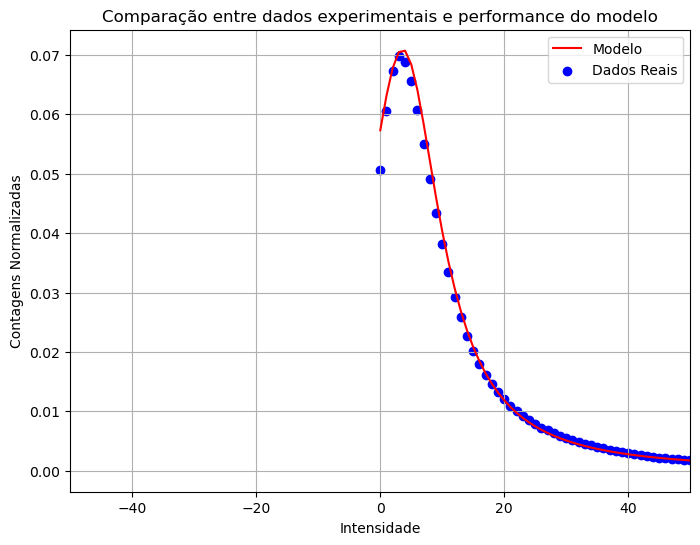

In [12]:
# domínio discreto
xs = np.arange(0, 596)   # 0..595 inclusive

y_estimado = func_normalizada(xs)

plt.figure(figsize=(8, 6))
plt.plot(xs, y_estimado, label='Modelo', color='red')
plt.scatter(valores, contagens/sum(contagens), label='Dados Reais', color='blue')
plt.title('Comparação entre dados experimentais e performance do modelo')
plt.xlabel('Intensidade')
plt.ylabel('Contagens Normalizadas')
plt.legend()
plt.grid(True)
plt.xlim(-50,50)
plt.show()


In [13]:
# Nessa célula geram-se os números inteiros pseudoaleatórios, segundo a distribuição! 
vals = func_normalizada(xs)

# assegurar não-negatividade (por garantia)
vals = np.clip(vals, 0, None).astype(np.float64)
prob = vals/sum(vals)         #Outra vez, para garantir que a soma das probabilidades seja 1

# gerar amostras pseudo-aleatórias
rng = np.random.default_rng()  # muda/retira seed se não deseja determinismo
N = 200000
samples = rng.choice(xs, size=N, p=prob)

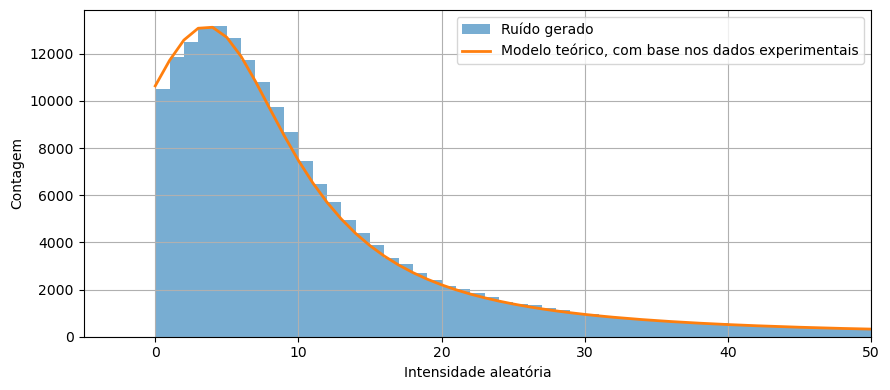

In [14]:
# histograma comparativo (frequências normalizadas vs. distribuição alvo)
plt.figure(figsize=(9,4))

# histograma das amostras (probabilidade empírica)
counts, bins, _ = plt.hist(samples, bins=range(0, 597), alpha=0.6, label="Ruído gerado")

# plot da probabilidade teórica discreta
plt.plot(xs, N*prob, lw=2, label="Modelo teórico, com base nos dados experimentais")
plt.xlim(0, 595)
plt.xlabel("Intensidade aleatória")
plt.ylabel("Contagem")
plt.legend()
plt.xlim(-5,50)
plt.tight_layout()
plt.grid(True)
plt.show()


In [15]:
print(razao/(1+((x-x0)/Gamma)**2))

0.0709307107483321/(0.237703668950957*(0.278947261501954*x - 1)**2 + 1)


In [ ]:
def normalized_probability_density_function(x):
    return 0.0709307107483321/(0.237703668950957*(0.278947261501954*x - 1)**2 + 1)

def generate_random_noise(N):
    # domínio discreto
    xs = np.arange(0, 596)   # 0..595 inclusive
    
    vals = normalized_probability_density_function(xs)
    
    # assegurar não-negatividade (por garantia)
    vals = np.clip(vals, 0, None).astype(np.float64)
    prob = vals/sum(vals)         #Outra vez, para garantir que a soma das probabilidades seja 1

    # gerar amostras pseudo-aleatórias
    rng = np.random.default_rng()  # muda/retira seed se não deseja determinismo
    
    noise = rng.choice(xs, size=N, p=prob)
    return noise

# Outros filtros
Usei esses outros filtros na tentativa de reduzir a quantidade de sinal suposto como ruído, especialmente nas bordas das fibras. Entretanto, o resultado foi indiferente e, aparentemente, essa quantidade de sinal suposto ruído não afetou a estimativa do espectro. Assim, mantive o uso do filtro Gaussiano por simplicidade!

In [ ]:
%%skip
# '''Exibir imagem SHG e estimativa de ruído com filtro mediana'''
from scipy.ndimage import median_filter
for i in range(len(archives_PL_list)):
    PL_image = ski.io.imread(os.path.join(path, archives_PL_list[i]))[0, :, :, 1]
    SHG_image = ski.io.imread(os.path.join(path, correspondent_archives_SHG[i]))[:, :, 1]
    SHG_image_normalizada = SHG_image/correspondent_accumulation_SHG[i]
    blur = median_filter(SHG_image_normalizada, size = 3)
    ruido_estimado = cv2.subtract(SHG_image_normalizada, blur)
    exib_figures(SHG_image, ruido_estimado, 
                 'pure_green', 'pure_green', 
                 np.max(SHG_image), np.max(ruido_estimado),
                 'SHG', 'Noise per accumulation',
                 path_and_name_figure = None)

In [ ]:
%%skip
'''Exibir imagem SHG e estimativa de ruído com filtro passa baixa gaussiano via scipy'''
from scipy.ndimage import gaussian_filter

for i in range(len(archives_PL_list)):
    PL_image = ski.io.imread(os.path.join(path, archives_PL_list[i]))[0, :, :, 1]
    SHG_image = ski.io.imread(os.path.join(path, correspondent_archives_SHG[i]))[:, :, 1]
    SHG_image_normalizada = SHG_image/correspondent_accumulation_SHG[i]
    lowpass = gaussian_filter(SHG_image_normalizada, sigma=3)
    ruido_estimado = SHG_image_normalizada - lowpass
    exib_figures(SHG_image, ruido_estimado, 
                 'pure_green', 'pure_green', 
                 np.max(SHG_image), np.max(ruido_estimado),
                 'SHG', 'Noise per accumulation',
                 path_and_name_figure = None)